# Machine Learning Foundation

## Course 5, Part d: Keras Intro LAB

## Using Keras to Build and Train Neural Networks

In this exercise we will use a neural network to predict diabetes using the Pima Diabetes Dataset.  We will start by training a Random Forest to get a performance baseline.  Then we will use the Keras package to quickly build and train a neural network and compare the performance.  We will see how different network structures affect the performance, training time, and level of overfitting (or underfitting).

## UCI Pima Diabetes Dataset

* UCI ML Repositiory (http://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes)


### Attributes: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

#### The UCI Pima Diabetes Dataset which has 8 numerical predictors and a binary outcome.

In [1]:
#Setup
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
## Load in the data set 
names = ["times_pregnant", "glucose_tolerance_test", "blood_pressure", "skin_thickness", "insulin", 
         "bmi", "pedigree_function", "age", "has_diabetes"]
diabetes_df = pd.read_csv('diabetes.csv', names=names, header=0)

In [4]:
print(diabetes_df.shape)
diabetes_df.sample(5)

(768, 9)


,times_pregnant,glucose_tolerance_test,blood_pressure,skin_thickness,insulin,bmi,pedigree_function,age,has_diabetes
76,7,62,78,0,0,32.6,0.391,41,0
306,10,161,68,23,132,25.5,0.326,47,1
515,3,163,70,18,105,31.6,0.268,28,1
134,2,96,68,13,49,21.1,0.647,26,0
428,0,135,94,46,145,40.6,0.284,26,0


In [5]:
X = diabetes_df.iloc[:, :-1].values #Input values
y = diabetes_df["has_diabetes"].values # Target value

In [6]:
# Split the data to Train, and Test (75%, 25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [7]:
np.mean(y), np.mean(1-y)

(0.3489583333333333, 0.6510416666666666)

- Above, we see that about 35% of the patients in this dataset have diabetes, while 65% do not.  
- This means we can get an accuracy of 65% without any model - just declare that no one has diabetes. 
- We will calculate the ROC-AUC score to evaluate performance of our model, and also look at the accuracy as well to see if we improved upon the 65% accuracy.

## Exercise 1: Get a baseline performance using Random Forest
To begin, and get a baseline for classifier performance:
1. Train a Random Forest model with 200 trees on the training data.
2. Calculate the accuracy and roc_auc_score of the predictions.

In [8]:
## Train the RF Model
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [9]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)

print(f"Accuracy is: {accuracy_score(y_test, y_pred_class_rf):.3f}")
print(f"Roc-Auc is: {roc_auc_score(y_test, y_pred_prob_rf[:, 1]):.3f}") # We just the positive classes probabilites.

Accuracy is: 0.714
Roc-Auc is: 0.802


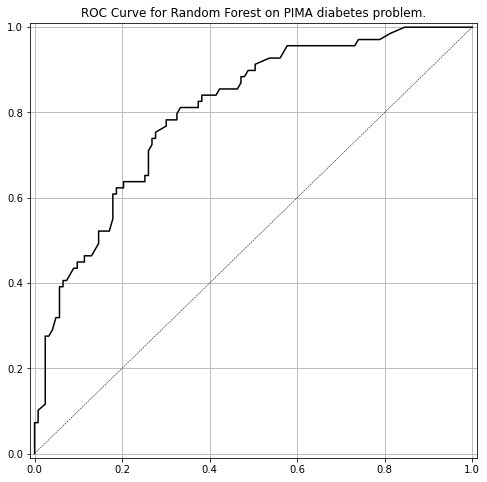

In [10]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title=f"ROC Curve for {model_name} on PIMA diabetes problem.",
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])

plot_roc(y_test, y_pred_prob_rf[:, 1], "Random Forest")

## Build a Single Hidden Layer Neural Network

- We will use the **Sequential model** to quickly build a neural network.
- Our first network will be a **single layer network**.  
- We have 8 variables, so we set the input shape to 8.  
- Let's start by having a single hidden layer with 12 nodes.

In [11]:
## First let's normalize the data
## This aids the training of neural nets by providing numerical stability
## Random Forest does not need this as it finds a split only, as opposed to performing matrix multiplications

normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

- Define the Model 
- Input size is 8-dimensional
- 1 hidden layer, 12 hidden nodes, sigmoid activation
- Final layer has just one node with a **sigmoid activation (standard for binary classification)**

In [12]:
model_1 = tf.keras.Sequential()
model_1.add(tf.keras.layers.Dense(12, input_shape=(8,), activation="sigmoid"))
model_1.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [13]:
#  This is a nice tool to view the model you have created and count the parameters

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                108       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


### Comprehension question:
- Why do we have 121 parameters?
    - We have 108 params in the first layer because: We have 8 input values in the Dense layer + a bias term = 9 values and we have 12 units in that layer. <br> So 12 x 9 = 108 params. 
    - Then to get to the next layer, again, you're going from 12 down to one, so it's going to be fully connected to that one plus the bias term so you have 12 plus that one, and that's going to be equal to 13,

In [14]:
# Fit(Train) the Model
# Compile the model with Optimizer, Loss Function and Metrics
opt = tf.keras.optimizers.SGD(learning_rate=0.003)
model_1.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train_norm, y_train, 
                         validation_data=(X_test_norm, y_test), epochs=200)


Epoch 1/200
18/18 [==============================] - 0s 9ms/step - loss: 1.0143 - accuracy: 0.3455 - val_loss: 0.9694 - val_accuracy: 0.3594
Epoch 2/200
18/18 [==============================] - 0s 2ms/step - loss: 0.9780 - accuracy: 0.3455 - val_loss: 0.9364 - val_accuracy: 0.3594
Epoch 3/200
18/18 [==============================] - 0s 2ms/step - loss: 0.9446 - accuracy: 0.3455 - val_loss: 0.9062 - val_accuracy: 0.3594
Epoch 4/200
18/18 [==============================] - 0s 2ms/step - loss: 0.9141 - accuracy: 0.3455 - val_loss: 0.8787 - val_accuracy: 0.3594
Epoch 5/200
18/18 [==============================] - 0s 2ms/step - loss: 0.8862 - accuracy: 0.3455 - val_loss: 0.8535 - val_accuracy: 0.3542
Epoch 6/200
18/18 [==============================] - 0s 2ms/step - loss: 0.8607 - accuracy: 0.3455 - val_loss: 0.8307 - val_accuracy: 0.3542
Epoch 7/200
18/18 [==============================] - 0s 2ms/step - loss: 0.8376 - accuracy: 0.3455 - val_loss: 0.8101 - val_accuracy: 0.3542
Epoch 8/200
1

Epoch 59/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5986 - accuracy: 0.6719 - val_loss: 0.6040 - val_accuracy: 0.6823
Epoch 60/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5978 - accuracy: 0.6719 - val_loss: 0.6034 - val_accuracy: 0.6823
Epoch 61/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5970 - accuracy: 0.6719 - val_loss: 0.6028 - val_accuracy: 0.6823
Epoch 62/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5963 - accuracy: 0.6736 - val_loss: 0.6021 - val_accuracy: 0.6823
Epoch 63/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5955 - accuracy: 0.6736 - val_loss: 0.6015 - val_accuracy: 0.6823
Epoch 64/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5948 - accuracy: 0.6736 - val_loss: 0.6009 - val_accuracy: 0.6823
Epoch 65/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5941 - accuracy: 0.6736 - val_loss: 0.6003 - val_accuracy: 0.6823
Epoch 

18/18 [==============================] - 0s 2ms/step - loss: 0.5633 - accuracy: 0.6979 - val_loss: 0.5742 - val_accuracy: 0.7135
Epoch 117/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5628 - accuracy: 0.6997 - val_loss: 0.5738 - val_accuracy: 0.7135
Epoch 118/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5622 - accuracy: 0.6979 - val_loss: 0.5734 - val_accuracy: 0.7135
Epoch 119/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5617 - accuracy: 0.6979 - val_loss: 0.5729 - val_accuracy: 0.7135
Epoch 120/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5612 - accuracy: 0.6997 - val_loss: 0.5725 - val_accuracy: 0.7135
Epoch 121/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5607 - accuracy: 0.6997 - val_loss: 0.5720 - val_accuracy: 0.7135
Epoch 122/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5602 - accuracy: 0.6997 - val_loss: 0.5716 - val_accuracy: 0.7135
Epoch 123/200

18/18 [==============================] - 0s 2ms/step - loss: 0.5371 - accuracy: 0.7396 - val_loss: 0.5525 - val_accuracy: 0.7344
Epoch 174/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5367 - accuracy: 0.7396 - val_loss: 0.5522 - val_accuracy: 0.7344
Epoch 175/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5363 - accuracy: 0.7396 - val_loss: 0.5519 - val_accuracy: 0.7292
Epoch 176/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5359 - accuracy: 0.7396 - val_loss: 0.5516 - val_accuracy: 0.7292
Epoch 177/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5355 - accuracy: 0.7396 - val_loss: 0.5513 - val_accuracy: 0.7292
Epoch 178/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5351 - accuracy: 0.7413 - val_loss: 0.5509 - val_accuracy: 0.7292
Epoch 179/200
18/18 [==============================] - 0s 2ms/step - loss: 0.5348 - accuracy: 0.7448 - val_loss: 0.5506 - val_accuracy: 0.7344
Epoch 180/200

In [15]:
## Like we did for the Random Forest, we generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score.

y_pred_class_nn_1 = model_1.predict_classes(X_test_norm)
y_pred_prob_nn_1 = model_1.predict(X_test_norm)

In [16]:
# Let's check out the outputs
y_pred_class_nn_1[:10]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1]])

In [17]:
y_pred_prob_nn_1[:10]

array([[0.34568253],
       [0.22897029],
       [0.26541758],
       [0.38674912],
       [0.47082052],
       [0.4123608 ],
       [0.13933143],
       [0.38799557],
       [0.42226028],
       [0.51163906]], dtype=float32)

Accuracy is: 0.734
Roc-Auc is: 0.801


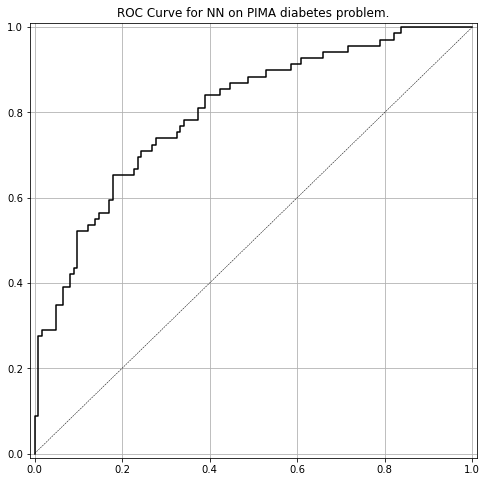

In [18]:
# Print model performance and plot the roc curve
print(f"Accuracy is: {accuracy_score(y_test, y_pred_class_nn_1):.3f}")
print(f"Roc-Auc is: {roc_auc_score(y_test, y_pred_prob_nn_1):.3f}")

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

Let's look at the `run_hist_1` object that was created, specifically its `history` attribute.

In [19]:
run_hist_1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Let's plot the training loss and the validation loss over the different epochs and see how it looks.

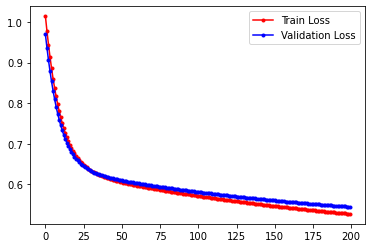

In [20]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"], "r", marker=".", label="Train Loss")
ax.plot(run_hist_1.history["val_loss"], "b", marker=".", label="Validation Loss")
ax.legend()

- Looks like the losses are still going down on both the training set and the validation set.
- This suggests that the model might benefit from further training.
- Let's train the model a little more and see what happens.
- Note that **it will pick up from where it left off.** 
- Train for 600 more epochs.

In [21]:
## Note that when we call "fit" again, it picks up where it left off
run_hist_1b = model_1.fit(X_train_norm, y_train, 
                          validation_data=(X_test_norm, y_test), epochs=600)

Epoch 1/600
18/18 [==============================] - 0s 3ms/step - loss: 0.5267 - accuracy: 0.7448 - val_loss: 0.5442 - val_accuracy: 0.7396
Epoch 2/600
18/18 [==============================] - 0s 2ms/step - loss: 0.5263 - accuracy: 0.7448 - val_loss: 0.5440 - val_accuracy: 0.7396
Epoch 3/600
18/18 [==============================] - 0s 2ms/step - loss: 0.5260 - accuracy: 0.7448 - val_loss: 0.5437 - val_accuracy: 0.7396
Epoch 4/600
18/18 [==============================] - 0s 2ms/step - loss: 0.5256 - accuracy: 0.7448 - val_loss: 0.5434 - val_accuracy: 0.7396
Epoch 5/600
18/18 [==============================] - 0s 2ms/step - loss: 0.5253 - accuracy: 0.7448 - val_loss: 0.5431 - val_accuracy: 0.7396
Epoch 6/600
18/18 [==============================] - 0s 2ms/step - loss: 0.5249 - accuracy: 0.7465 - val_loss: 0.5429 - val_accuracy: 0.7396
Epoch 7/600
18/18 [==============================] - 0s 2ms/step - loss: 0.5246 - accuracy: 0.7483 - val_loss: 0.5426 - val_accuracy: 0.7396
Epoch 8/600
1

Epoch 59/600
18/18 [==============================] - 0s 2ms/step - loss: 0.5091 - accuracy: 0.7500 - val_loss: 0.5310 - val_accuracy: 0.7552
Epoch 60/600
18/18 [==============================] - 0s 2ms/step - loss: 0.5089 - accuracy: 0.7500 - val_loss: 0.5308 - val_accuracy: 0.7552
Epoch 61/600
18/18 [==============================] - 0s 2ms/step - loss: 0.5086 - accuracy: 0.7483 - val_loss: 0.5306 - val_accuracy: 0.7552
Epoch 62/600
18/18 [==============================] - 0s 2ms/step - loss: 0.5084 - accuracy: 0.7500 - val_loss: 0.5304 - val_accuracy: 0.7552
Epoch 63/600
18/18 [==============================] - 0s 2ms/step - loss: 0.5081 - accuracy: 0.7483 - val_loss: 0.5302 - val_accuracy: 0.7552
Epoch 64/600
18/18 [==============================] - 0s 2ms/step - loss: 0.5078 - accuracy: 0.7483 - val_loss: 0.5301 - val_accuracy: 0.7552
Epoch 65/600
18/18 [==============================] - 0s 2ms/step - loss: 0.5076 - accuracy: 0.7483 - val_loss: 0.5299 - val_accuracy: 0.7500
Epoch 

18/18 [==============================] - 0s 2ms/step - loss: 0.4963 - accuracy: 0.7587 - val_loss: 0.5221 - val_accuracy: 0.7656
Epoch 117/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4961 - accuracy: 0.7587 - val_loss: 0.5219 - val_accuracy: 0.7656
Epoch 118/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4959 - accuracy: 0.7587 - val_loss: 0.5218 - val_accuracy: 0.7656
Epoch 119/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4957 - accuracy: 0.7587 - val_loss: 0.5217 - val_accuracy: 0.7656
Epoch 120/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4955 - accuracy: 0.7587 - val_loss: 0.5215 - val_accuracy: 0.7656
Epoch 121/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4953 - accuracy: 0.7587 - val_loss: 0.5214 - val_accuracy: 0.7656
Epoch 122/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4951 - accuracy: 0.7587 - val_loss: 0.5213 - val_accuracy: 0.7656
Epoch 123/600

18/18 [==============================] - 0s 2ms/step - loss: 0.4867 - accuracy: 0.7691 - val_loss: 0.5160 - val_accuracy: 0.7604
Epoch 174/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4865 - accuracy: 0.7691 - val_loss: 0.5160 - val_accuracy: 0.7656
Epoch 175/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4864 - accuracy: 0.7708 - val_loss: 0.5159 - val_accuracy: 0.7656
Epoch 176/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4862 - accuracy: 0.7708 - val_loss: 0.5158 - val_accuracy: 0.7656
Epoch 177/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4861 - accuracy: 0.7708 - val_loss: 0.5157 - val_accuracy: 0.7656
Epoch 178/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4859 - accuracy: 0.7708 - val_loss: 0.5156 - val_accuracy: 0.7656
Epoch 179/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4858 - accuracy: 0.7708 - val_loss: 0.5155 - val_accuracy: 0.7656
Epoch 180/600

18/18 [==============================] - 0s 2ms/step - loss: 0.4794 - accuracy: 0.7760 - val_loss: 0.5121 - val_accuracy: 0.7812
Epoch 231/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4793 - accuracy: 0.7726 - val_loss: 0.5120 - val_accuracy: 0.7812
Epoch 232/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4792 - accuracy: 0.7760 - val_loss: 0.5119 - val_accuracy: 0.7812
Epoch 233/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4790 - accuracy: 0.7743 - val_loss: 0.5119 - val_accuracy: 0.7812
Epoch 234/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4789 - accuracy: 0.7760 - val_loss: 0.5118 - val_accuracy: 0.7812
Epoch 235/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4788 - accuracy: 0.7743 - val_loss: 0.5118 - val_accuracy: 0.7812
Epoch 236/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4787 - accuracy: 0.7743 - val_loss: 0.5117 - val_accuracy: 0.7760
Epoch 237/600

18/18 [==============================] - 0s 2ms/step - loss: 0.4738 - accuracy: 0.7743 - val_loss: 0.5095 - val_accuracy: 0.7760
Epoch 288/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4737 - accuracy: 0.7743 - val_loss: 0.5094 - val_accuracy: 0.7760
Epoch 289/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4736 - accuracy: 0.7743 - val_loss: 0.5094 - val_accuracy: 0.7760
Epoch 290/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4735 - accuracy: 0.7743 - val_loss: 0.5094 - val_accuracy: 0.7760
Epoch 291/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4735 - accuracy: 0.7743 - val_loss: 0.5093 - val_accuracy: 0.7760
Epoch 292/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4734 - accuracy: 0.7743 - val_loss: 0.5093 - val_accuracy: 0.7760
Epoch 293/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4733 - accuracy: 0.7743 - val_loss: 0.5093 - val_accuracy: 0.7760
Epoch 294/600

18/18 [==============================] - 0s 2ms/step - loss: 0.4694 - accuracy: 0.7743 - val_loss: 0.5079 - val_accuracy: 0.7604
Epoch 345/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4694 - accuracy: 0.7743 - val_loss: 0.5078 - val_accuracy: 0.7604
Epoch 346/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4693 - accuracy: 0.7743 - val_loss: 0.5078 - val_accuracy: 0.7604
Epoch 347/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4692 - accuracy: 0.7760 - val_loss: 0.5078 - val_accuracy: 0.7604
Epoch 348/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4692 - accuracy: 0.7760 - val_loss: 0.5078 - val_accuracy: 0.7604
Epoch 349/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4691 - accuracy: 0.7760 - val_loss: 0.5078 - val_accuracy: 0.7604
Epoch 350/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4690 - accuracy: 0.7760 - val_loss: 0.5077 - val_accuracy: 0.7604
Epoch 351/600

18/18 [==============================] - 0s 2ms/step - loss: 0.4660 - accuracy: 0.7778 - val_loss: 0.5069 - val_accuracy: 0.7552
Epoch 402/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4659 - accuracy: 0.7778 - val_loss: 0.5069 - val_accuracy: 0.7552
Epoch 403/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4659 - accuracy: 0.7778 - val_loss: 0.5069 - val_accuracy: 0.7552
Epoch 404/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4658 - accuracy: 0.7778 - val_loss: 0.5069 - val_accuracy: 0.7552
Epoch 405/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4658 - accuracy: 0.7778 - val_loss: 0.5069 - val_accuracy: 0.7552
Epoch 406/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4657 - accuracy: 0.7778 - val_loss: 0.5068 - val_accuracy: 0.7552
Epoch 407/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4657 - accuracy: 0.7778 - val_loss: 0.5068 - val_accuracy: 0.7552
Epoch 408/600

18/18 [==============================] - 0s 2ms/step - loss: 0.4632 - accuracy: 0.7795 - val_loss: 0.5064 - val_accuracy: 0.7552
Epoch 459/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4631 - accuracy: 0.7795 - val_loss: 0.5064 - val_accuracy: 0.7552
Epoch 460/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4631 - accuracy: 0.7795 - val_loss: 0.5064 - val_accuracy: 0.7552
Epoch 461/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4630 - accuracy: 0.7795 - val_loss: 0.5064 - val_accuracy: 0.7552
Epoch 462/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4630 - accuracy: 0.7795 - val_loss: 0.5064 - val_accuracy: 0.7552
Epoch 463/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4629 - accuracy: 0.7795 - val_loss: 0.5064 - val_accuracy: 0.7552
Epoch 464/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4629 - accuracy: 0.7795 - val_loss: 0.5064 - val_accuracy: 0.7552
Epoch 465/600

18/18 [==============================] - 0s 2ms/step - loss: 0.4609 - accuracy: 0.7830 - val_loss: 0.5063 - val_accuracy: 0.7552
Epoch 516/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4608 - accuracy: 0.7830 - val_loss: 0.5063 - val_accuracy: 0.7552
Epoch 517/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4608 - accuracy: 0.7830 - val_loss: 0.5063 - val_accuracy: 0.7552
Epoch 518/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4608 - accuracy: 0.7830 - val_loss: 0.5063 - val_accuracy: 0.7552
Epoch 519/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4607 - accuracy: 0.7830 - val_loss: 0.5063 - val_accuracy: 0.7604
Epoch 520/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4607 - accuracy: 0.7830 - val_loss: 0.5063 - val_accuracy: 0.7604
Epoch 521/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4606 - accuracy: 0.7830 - val_loss: 0.5063 - val_accuracy: 0.7604
Epoch 522/600

18/18 [==============================] - 0s 2ms/step - loss: 0.4589 - accuracy: 0.7795 - val_loss: 0.5063 - val_accuracy: 0.7656
Epoch 573/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4589 - accuracy: 0.7812 - val_loss: 0.5064 - val_accuracy: 0.7656
Epoch 574/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4588 - accuracy: 0.7795 - val_loss: 0.5064 - val_accuracy: 0.7656
Epoch 575/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4588 - accuracy: 0.7812 - val_loss: 0.5064 - val_accuracy: 0.7656
Epoch 576/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4588 - accuracy: 0.7812 - val_loss: 0.5064 - val_accuracy: 0.7656
Epoch 577/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4588 - accuracy: 0.7812 - val_loss: 0.5064 - val_accuracy: 0.7656
Epoch 578/600
18/18 [==============================] - 0s 2ms/step - loss: 0.4587 - accuracy: 0.7812 - val_loss: 0.5064 - val_accuracy: 0.7656
Epoch 579/600

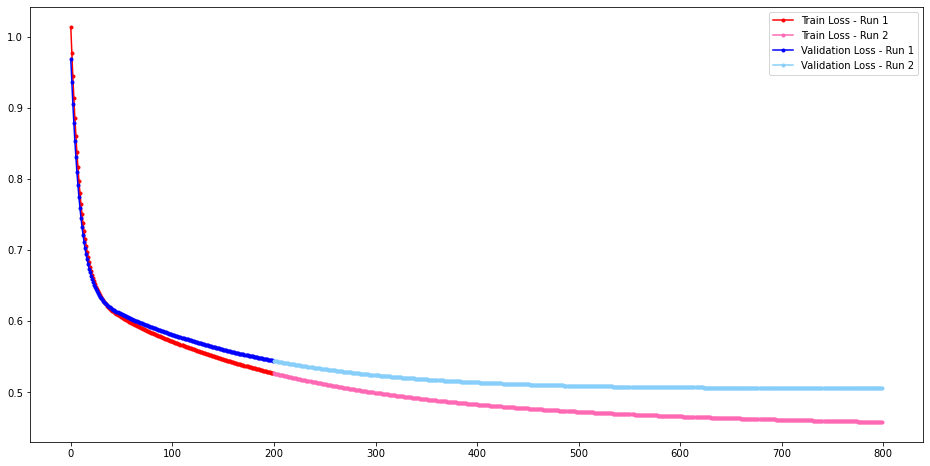

In [22]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

- Note that this graph begins where the other left off.  
- While the training loss is still going down, it looks like the validation loss has stabilized (or even gotten worse!).  
- This suggests that our network will not benefit from further training. 

## Exercise 2
For this exercise, do the following in the cells below:
- Build a model with two hidden layers, each with 6 nodes
- Use the "relu" activation function for the hidden layers, and "sigmoid" for the final layer
- Use a learning rate of .003 and train for 1500 epochs
- Graph the trajectory of the loss functions, accuracy on both train and test set
- Plot the roc curve for the predictions

Experiment with different learning rates, numbers of epochs, and network structures

In [23]:
model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Dense(6, input_shape=(8,), activation="relu"))
model_2.add(tf.keras.layers.Dense(6, activation="relu"))
model_2.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model_2.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
run_hist_2 = model_2.fit(X_train_norm, y_train, 
                         validation_data=(X_test_norm, y_test), epochs=1500)

Epoch 1/1500
18/18 [==============================] - 0s 8ms/step - loss: 0.6497 - accuracy: 0.6493 - val_loss: 0.6341 - val_accuracy: 0.6719
Epoch 2/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6478 - accuracy: 0.6493 - val_loss: 0.6326 - val_accuracy: 0.6719
Epoch 3/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6459 - accuracy: 0.6510 - val_loss: 0.6311 - val_accuracy: 0.6719
Epoch 4/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6441 - accuracy: 0.6528 - val_loss: 0.6296 - val_accuracy: 0.6719
Epoch 5/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6423 - accuracy: 0.6597 - val_loss: 0.6281 - val_accuracy: 0.6667
Epoch 6/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6406 - accuracy: 0.6667 - val_loss: 0.6266 - val_accuracy: 0.6719
Epoch 7/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.6388 - accuracy: 0.6632 - val_loss: 0.6251 - val_accuracy: 0.6719
Epoch 

18/18 [==============================] - 0s 2ms/step - loss: 0.5670 - accuracy: 0.7118 - val_loss: 0.5604 - val_accuracy: 0.7031
Epoch 59/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5659 - accuracy: 0.7135 - val_loss: 0.5594 - val_accuracy: 0.7031
Epoch 60/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5648 - accuracy: 0.7153 - val_loss: 0.5585 - val_accuracy: 0.7031
Epoch 61/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5637 - accuracy: 0.7170 - val_loss: 0.5576 - val_accuracy: 0.7083
Epoch 62/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5626 - accuracy: 0.7170 - val_loss: 0.5567 - val_accuracy: 0.7083
Epoch 63/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5615 - accuracy: 0.7170 - val_loss: 0.5558 - val_accuracy: 0.7083
Epoch 64/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5605 - accuracy: 0.7170 - val_loss: 0.5549 - val_accuracy: 0.7083
Epoch 65/1500

18/18 [==============================] - 0s 2ms/step - loss: 0.5156 - accuracy: 0.7361 - val_loss: 0.5225 - val_accuracy: 0.7448
Epoch 116/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5150 - accuracy: 0.7413 - val_loss: 0.5222 - val_accuracy: 0.7396
Epoch 117/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5143 - accuracy: 0.7413 - val_loss: 0.5218 - val_accuracy: 0.7396
Epoch 118/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5136 - accuracy: 0.7413 - val_loss: 0.5214 - val_accuracy: 0.7344
Epoch 119/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5129 - accuracy: 0.7448 - val_loss: 0.5211 - val_accuracy: 0.7344
Epoch 120/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5122 - accuracy: 0.7465 - val_loss: 0.5207 - val_accuracy: 0.7344
Epoch 121/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.5116 - accuracy: 0.7465 - val_loss: 0.5204 - val_accuracy: 0.7344
Epoch 1

Epoch 172/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4859 - accuracy: 0.7535 - val_loss: 0.5129 - val_accuracy: 0.7708
Epoch 173/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4856 - accuracy: 0.7517 - val_loss: 0.5129 - val_accuracy: 0.7708
Epoch 174/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4852 - accuracy: 0.7500 - val_loss: 0.5129 - val_accuracy: 0.7708
Epoch 175/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4848 - accuracy: 0.7517 - val_loss: 0.5129 - val_accuracy: 0.7708
Epoch 176/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4845 - accuracy: 0.7517 - val_loss: 0.5129 - val_accuracy: 0.7708
Epoch 177/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4841 - accuracy: 0.7517 - val_loss: 0.5129 - val_accuracy: 0.7708
Epoch 178/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4838 - accuracy: 0.7517 - val_loss: 0.5129 - val_accuracy:

Epoch 229/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4685 - accuracy: 0.7622 - val_loss: 0.5158 - val_accuracy: 0.7708
Epoch 230/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4682 - accuracy: 0.7639 - val_loss: 0.5158 - val_accuracy: 0.7708
Epoch 231/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4680 - accuracy: 0.7639 - val_loss: 0.5159 - val_accuracy: 0.7708
Epoch 232/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4677 - accuracy: 0.7656 - val_loss: 0.5160 - val_accuracy: 0.7708
Epoch 233/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4675 - accuracy: 0.7656 - val_loss: 0.5161 - val_accuracy: 0.7656
Epoch 234/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4672 - accuracy: 0.7656 - val_loss: 0.5162 - val_accuracy: 0.7656
Epoch 235/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4670 - accuracy: 0.7656 - val_loss: 0.5162 - val_accuracy:

Epoch 286/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4576 - accuracy: 0.7708 - val_loss: 0.5208 - val_accuracy: 0.7500
Epoch 287/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4574 - accuracy: 0.7674 - val_loss: 0.5208 - val_accuracy: 0.7500
Epoch 288/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4573 - accuracy: 0.7674 - val_loss: 0.5209 - val_accuracy: 0.7500
Epoch 289/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4572 - accuracy: 0.7691 - val_loss: 0.5210 - val_accuracy: 0.7500
Epoch 290/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4571 - accuracy: 0.7726 - val_loss: 0.5210 - val_accuracy: 0.7500
Epoch 291/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4569 - accuracy: 0.7708 - val_loss: 0.5211 - val_accuracy: 0.7500
Epoch 292/1500
18/18 [==============================] - 0s 1ms/step - loss: 0.4568 - accuracy: 0.7726 - val_loss: 0.5212 - val_accuracy:

Epoch 343/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4517 - accuracy: 0.7795 - val_loss: 0.5239 - val_accuracy: 0.7656
Epoch 344/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4516 - accuracy: 0.7795 - val_loss: 0.5240 - val_accuracy: 0.7656
Epoch 345/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4516 - accuracy: 0.7795 - val_loss: 0.5240 - val_accuracy: 0.7656
Epoch 346/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4515 - accuracy: 0.7795 - val_loss: 0.5240 - val_accuracy: 0.7656
Epoch 347/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4514 - accuracy: 0.7795 - val_loss: 0.5240 - val_accuracy: 0.7656
Epoch 348/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4513 - accuracy: 0.7795 - val_loss: 0.5241 - val_accuracy: 0.7656
Epoch 349/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4512 - accuracy: 0.7795 - val_loss: 0.5241 - val_accuracy:

Epoch 400/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4470 - accuracy: 0.7830 - val_loss: 0.5268 - val_accuracy: 0.7552
Epoch 401/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4469 - accuracy: 0.7830 - val_loss: 0.5269 - val_accuracy: 0.7552
Epoch 402/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4468 - accuracy: 0.7830 - val_loss: 0.5269 - val_accuracy: 0.7552
Epoch 403/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4467 - accuracy: 0.7830 - val_loss: 0.5270 - val_accuracy: 0.7552
Epoch 404/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4467 - accuracy: 0.7830 - val_loss: 0.5271 - val_accuracy: 0.7552
Epoch 405/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4465 - accuracy: 0.7830 - val_loss: 0.5272 - val_accuracy: 0.7552
Epoch 406/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4465 - accuracy: 0.7830 - val_loss: 0.5272 - val_accuracy:

Epoch 457/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4431 - accuracy: 0.7865 - val_loss: 0.5304 - val_accuracy: 0.7396
Epoch 458/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4430 - accuracy: 0.7882 - val_loss: 0.5305 - val_accuracy: 0.7396
Epoch 459/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4429 - accuracy: 0.7882 - val_loss: 0.5306 - val_accuracy: 0.7396
Epoch 460/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4428 - accuracy: 0.7865 - val_loss: 0.5307 - val_accuracy: 0.7396
Epoch 461/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4428 - accuracy: 0.7899 - val_loss: 0.5307 - val_accuracy: 0.7396
Epoch 462/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4427 - accuracy: 0.7882 - val_loss: 0.5308 - val_accuracy: 0.7396
Epoch 463/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4427 - accuracy: 0.7882 - val_loss: 0.5308 - val_accuracy:

Epoch 514/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4393 - accuracy: 0.7917 - val_loss: 0.5335 - val_accuracy: 0.7396
Epoch 515/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4393 - accuracy: 0.7917 - val_loss: 0.5336 - val_accuracy: 0.7396
Epoch 516/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4392 - accuracy: 0.7917 - val_loss: 0.5336 - val_accuracy: 0.7396
Epoch 517/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4392 - accuracy: 0.7917 - val_loss: 0.5337 - val_accuracy: 0.7396
Epoch 518/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4391 - accuracy: 0.7917 - val_loss: 0.5338 - val_accuracy: 0.7396
Epoch 519/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4390 - accuracy: 0.7917 - val_loss: 0.5338 - val_accuracy: 0.7396
Epoch 520/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4389 - accuracy: 0.7917 - val_loss: 0.5339 - val_accuracy:

Epoch 571/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4363 - accuracy: 0.7934 - val_loss: 0.5365 - val_accuracy: 0.7396
Epoch 572/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4363 - accuracy: 0.7934 - val_loss: 0.5365 - val_accuracy: 0.7396
Epoch 573/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4363 - accuracy: 0.7934 - val_loss: 0.5366 - val_accuracy: 0.7396
Epoch 574/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4362 - accuracy: 0.7934 - val_loss: 0.5366 - val_accuracy: 0.7396
Epoch 575/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4362 - accuracy: 0.7934 - val_loss: 0.5367 - val_accuracy: 0.7396
Epoch 576/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4361 - accuracy: 0.7934 - val_loss: 0.5367 - val_accuracy: 0.7396
Epoch 577/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4361 - accuracy: 0.7934 - val_loss: 0.5368 - val_accuracy:

Epoch 628/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4337 - accuracy: 0.7969 - val_loss: 0.5398 - val_accuracy: 0.7500
Epoch 629/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4337 - accuracy: 0.7969 - val_loss: 0.5399 - val_accuracy: 0.7500
Epoch 630/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4337 - accuracy: 0.7969 - val_loss: 0.5400 - val_accuracy: 0.7500
Epoch 631/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4336 - accuracy: 0.7969 - val_loss: 0.5400 - val_accuracy: 0.7500
Epoch 632/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4336 - accuracy: 0.7969 - val_loss: 0.5401 - val_accuracy: 0.7500
Epoch 633/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4335 - accuracy: 0.7969 - val_loss: 0.5401 - val_accuracy: 0.7500
Epoch 634/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4335 - accuracy: 0.7969 - val_loss: 0.5402 - val_accuracy:

Epoch 685/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4315 - accuracy: 0.7951 - val_loss: 0.5422 - val_accuracy: 0.7500
Epoch 686/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4315 - accuracy: 0.7951 - val_loss: 0.5423 - val_accuracy: 0.7500
Epoch 687/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4314 - accuracy: 0.7951 - val_loss: 0.5423 - val_accuracy: 0.7500
Epoch 688/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4314 - accuracy: 0.7951 - val_loss: 0.5423 - val_accuracy: 0.7500
Epoch 689/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4313 - accuracy: 0.7951 - val_loss: 0.5423 - val_accuracy: 0.7500
Epoch 690/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4313 - accuracy: 0.7951 - val_loss: 0.5423 - val_accuracy: 0.7500
Epoch 691/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4313 - accuracy: 0.7951 - val_loss: 0.5423 - val_accuracy:

Epoch 742/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4297 - accuracy: 0.7899 - val_loss: 0.5430 - val_accuracy: 0.7552
Epoch 743/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4296 - accuracy: 0.7899 - val_loss: 0.5430 - val_accuracy: 0.7552
Epoch 744/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4296 - accuracy: 0.7899 - val_loss: 0.5430 - val_accuracy: 0.7552
Epoch 745/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4296 - accuracy: 0.7899 - val_loss: 0.5430 - val_accuracy: 0.7552
Epoch 746/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4296 - accuracy: 0.7899 - val_loss: 0.5430 - val_accuracy: 0.7552
Epoch 747/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4295 - accuracy: 0.7899 - val_loss: 0.5430 - val_accuracy: 0.7552
Epoch 748/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4296 - accuracy: 0.7899 - val_loss: 0.5430 - val_accuracy:

Epoch 799/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4281 - accuracy: 0.7951 - val_loss: 0.5431 - val_accuracy: 0.7448
Epoch 800/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4281 - accuracy: 0.7951 - val_loss: 0.5431 - val_accuracy: 0.7448
Epoch 801/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4281 - accuracy: 0.7951 - val_loss: 0.5432 - val_accuracy: 0.7448
Epoch 802/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4281 - accuracy: 0.7951 - val_loss: 0.5431 - val_accuracy: 0.7448
Epoch 803/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4281 - accuracy: 0.7951 - val_loss: 0.5431 - val_accuracy: 0.7448
Epoch 804/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4280 - accuracy: 0.7969 - val_loss: 0.5431 - val_accuracy: 0.7448
Epoch 805/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4280 - accuracy: 0.7969 - val_loss: 0.5432 - val_accuracy:

Epoch 856/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4270 - accuracy: 0.7951 - val_loss: 0.5433 - val_accuracy: 0.7448
Epoch 857/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4270 - accuracy: 0.7951 - val_loss: 0.5433 - val_accuracy: 0.7448
Epoch 858/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4270 - accuracy: 0.7951 - val_loss: 0.5433 - val_accuracy: 0.7448
Epoch 859/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4270 - accuracy: 0.7951 - val_loss: 0.5434 - val_accuracy: 0.7448
Epoch 860/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4269 - accuracy: 0.7951 - val_loss: 0.5434 - val_accuracy: 0.7448
Epoch 861/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4269 - accuracy: 0.7951 - val_loss: 0.5434 - val_accuracy: 0.7448
Epoch 862/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4269 - accuracy: 0.7951 - val_loss: 0.5434 - val_accuracy:

Epoch 913/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4260 - accuracy: 0.7899 - val_loss: 0.5438 - val_accuracy: 0.7448
Epoch 914/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4259 - accuracy: 0.7899 - val_loss: 0.5438 - val_accuracy: 0.7396
Epoch 915/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4259 - accuracy: 0.7899 - val_loss: 0.5438 - val_accuracy: 0.7396
Epoch 916/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4259 - accuracy: 0.7899 - val_loss: 0.5438 - val_accuracy: 0.7396
Epoch 917/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4259 - accuracy: 0.7899 - val_loss: 0.5439 - val_accuracy: 0.7396
Epoch 918/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4259 - accuracy: 0.7899 - val_loss: 0.5439 - val_accuracy: 0.7396
Epoch 919/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4258 - accuracy: 0.7899 - val_loss: 0.5439 - val_accuracy:

Epoch 970/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4248 - accuracy: 0.7899 - val_loss: 0.5457 - val_accuracy: 0.7396
Epoch 971/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4248 - accuracy: 0.7899 - val_loss: 0.5457 - val_accuracy: 0.7396
Epoch 972/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4248 - accuracy: 0.7899 - val_loss: 0.5458 - val_accuracy: 0.7396
Epoch 973/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4248 - accuracy: 0.7899 - val_loss: 0.5458 - val_accuracy: 0.7396
Epoch 974/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4248 - accuracy: 0.7899 - val_loss: 0.5458 - val_accuracy: 0.7396
Epoch 975/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4248 - accuracy: 0.7899 - val_loss: 0.5459 - val_accuracy: 0.7396
Epoch 976/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4247 - accuracy: 0.7899 - val_loss: 0.5459 - val_accuracy:

Epoch 1027/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4238 - accuracy: 0.7917 - val_loss: 0.5474 - val_accuracy: 0.7344
Epoch 1028/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4238 - accuracy: 0.7917 - val_loss: 0.5474 - val_accuracy: 0.7344
Epoch 1029/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4238 - accuracy: 0.7917 - val_loss: 0.5474 - val_accuracy: 0.7344
Epoch 1030/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4238 - accuracy: 0.7917 - val_loss: 0.5475 - val_accuracy: 0.7344
Epoch 1031/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4238 - accuracy: 0.7934 - val_loss: 0.5475 - val_accuracy: 0.7344
Epoch 1032/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4237 - accuracy: 0.7917 - val_loss: 0.5475 - val_accuracy: 0.7344
Epoch 1033/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4238 - accuracy: 0.7917 - val_loss: 0.5476 - val_ac

18/18 [==============================] - 0s 2ms/step - loss: 0.4229 - accuracy: 0.7951 - val_loss: 0.5484 - val_accuracy: 0.7344
Epoch 1084/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4229 - accuracy: 0.7951 - val_loss: 0.5484 - val_accuracy: 0.7292
Epoch 1085/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4229 - accuracy: 0.7934 - val_loss: 0.5484 - val_accuracy: 0.7292
Epoch 1086/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4228 - accuracy: 0.7951 - val_loss: 0.5484 - val_accuracy: 0.7292
Epoch 1087/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4228 - accuracy: 0.7951 - val_loss: 0.5484 - val_accuracy: 0.7292
Epoch 1088/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4228 - accuracy: 0.7951 - val_loss: 0.5484 - val_accuracy: 0.7292
Epoch 1089/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4228 - accuracy: 0.7951 - val_loss: 0.5484 - val_accuracy: 0.7292
E

18/18 [==============================] - 0s 2ms/step - loss: 0.4220 - accuracy: 0.7951 - val_loss: 0.5487 - val_accuracy: 0.7292
Epoch 1140/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4220 - accuracy: 0.7951 - val_loss: 0.5487 - val_accuracy: 0.7292
Epoch 1141/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4219 - accuracy: 0.7951 - val_loss: 0.5487 - val_accuracy: 0.7292
Epoch 1142/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4219 - accuracy: 0.7951 - val_loss: 0.5488 - val_accuracy: 0.7292
Epoch 1143/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4219 - accuracy: 0.7951 - val_loss: 0.5488 - val_accuracy: 0.7292
Epoch 1144/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4219 - accuracy: 0.7951 - val_loss: 0.5488 - val_accuracy: 0.7292
Epoch 1145/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4219 - accuracy: 0.7951 - val_loss: 0.5488 - val_accuracy: 0.7292
E

18/18 [==============================] - 0s 2ms/step - loss: 0.4212 - accuracy: 0.7969 - val_loss: 0.5495 - val_accuracy: 0.7292
Epoch 1196/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4211 - accuracy: 0.7969 - val_loss: 0.5496 - val_accuracy: 0.7292
Epoch 1197/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4211 - accuracy: 0.7969 - val_loss: 0.5496 - val_accuracy: 0.7292
Epoch 1198/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4211 - accuracy: 0.7951 - val_loss: 0.5496 - val_accuracy: 0.7292
Epoch 1199/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4211 - accuracy: 0.7969 - val_loss: 0.5496 - val_accuracy: 0.7292
Epoch 1200/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4211 - accuracy: 0.7951 - val_loss: 0.5496 - val_accuracy: 0.7292
Epoch 1201/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4211 - accuracy: 0.7969 - val_loss: 0.5497 - val_accuracy: 0.7292
E

18/18 [==============================] - 0s 2ms/step - loss: 0.4202 - accuracy: 0.7969 - val_loss: 0.5504 - val_accuracy: 0.7292
Epoch 1252/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4202 - accuracy: 0.7969 - val_loss: 0.5504 - val_accuracy: 0.7292
Epoch 1253/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4201 - accuracy: 0.7986 - val_loss: 0.5504 - val_accuracy: 0.7292
Epoch 1254/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4201 - accuracy: 0.7986 - val_loss: 0.5504 - val_accuracy: 0.7292
Epoch 1255/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4201 - accuracy: 0.8003 - val_loss: 0.5504 - val_accuracy: 0.7292
Epoch 1256/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4201 - accuracy: 0.7969 - val_loss: 0.5504 - val_accuracy: 0.7292
Epoch 1257/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4201 - accuracy: 0.7969 - val_loss: 0.5504 - val_accuracy: 0.7292
E

18/18 [==============================] - 0s 2ms/step - loss: 0.4192 - accuracy: 0.7986 - val_loss: 0.5513 - val_accuracy: 0.7344
Epoch 1308/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4191 - accuracy: 0.7986 - val_loss: 0.5513 - val_accuracy: 0.7344
Epoch 1309/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4191 - accuracy: 0.7986 - val_loss: 0.5513 - val_accuracy: 0.7344
Epoch 1310/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4191 - accuracy: 0.7986 - val_loss: 0.5514 - val_accuracy: 0.7344
Epoch 1311/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4191 - accuracy: 0.7969 - val_loss: 0.5514 - val_accuracy: 0.7344
Epoch 1312/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4190 - accuracy: 0.7986 - val_loss: 0.5514 - val_accuracy: 0.7344
Epoch 1313/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4191 - accuracy: 0.7986 - val_loss: 0.5515 - val_accuracy: 0.7344
E

18/18 [==============================] - 0s 2ms/step - loss: 0.4181 - accuracy: 0.8003 - val_loss: 0.5526 - val_accuracy: 0.7344
Epoch 1364/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4181 - accuracy: 0.8021 - val_loss: 0.5526 - val_accuracy: 0.7344
Epoch 1365/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4181 - accuracy: 0.8003 - val_loss: 0.5526 - val_accuracy: 0.7344
Epoch 1366/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4180 - accuracy: 0.8038 - val_loss: 0.5527 - val_accuracy: 0.7344
Epoch 1367/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4180 - accuracy: 0.8003 - val_loss: 0.5527 - val_accuracy: 0.7344
Epoch 1368/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4180 - accuracy: 0.8021 - val_loss: 0.5527 - val_accuracy: 0.7344
Epoch 1369/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4179 - accuracy: 0.8003 - val_loss: 0.5527 - val_accuracy: 0.7344
E

18/18 [==============================] - 0s 2ms/step - loss: 0.4172 - accuracy: 0.8003 - val_loss: 0.5537 - val_accuracy: 0.7292
Epoch 1420/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4171 - accuracy: 0.8021 - val_loss: 0.5537 - val_accuracy: 0.7292
Epoch 1421/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4172 - accuracy: 0.8021 - val_loss: 0.5537 - val_accuracy: 0.7292
Epoch 1422/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4171 - accuracy: 0.7986 - val_loss: 0.5537 - val_accuracy: 0.7292
Epoch 1423/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4171 - accuracy: 0.8003 - val_loss: 0.5537 - val_accuracy: 0.7240
Epoch 1424/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4171 - accuracy: 0.8021 - val_loss: 0.5537 - val_accuracy: 0.7240
Epoch 1425/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4171 - accuracy: 0.7986 - val_loss: 0.5537 - val_accuracy: 0.7240
E

18/18 [==============================] - 0s 2ms/step - loss: 0.4160 - accuracy: 0.8003 - val_loss: 0.5535 - val_accuracy: 0.7135
Epoch 1476/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4160 - accuracy: 0.8003 - val_loss: 0.5535 - val_accuracy: 0.7135
Epoch 1477/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4160 - accuracy: 0.7986 - val_loss: 0.5535 - val_accuracy: 0.7135
Epoch 1478/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4160 - accuracy: 0.8003 - val_loss: 0.5535 - val_accuracy: 0.7188
Epoch 1479/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4160 - accuracy: 0.7986 - val_loss: 0.5535 - val_accuracy: 0.7188
Epoch 1480/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4159 - accuracy: 0.8003 - val_loss: 0.5535 - val_accuracy: 0.7188
Epoch 1481/1500
18/18 [==============================] - 0s 2ms/step - loss: 0.4159 - accuracy: 0.7986 - val_loss: 0.5535 - val_accuracy: 0.7188
E

In [24]:
run_hist_2.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 1.0, 'Accuracy over iterations')

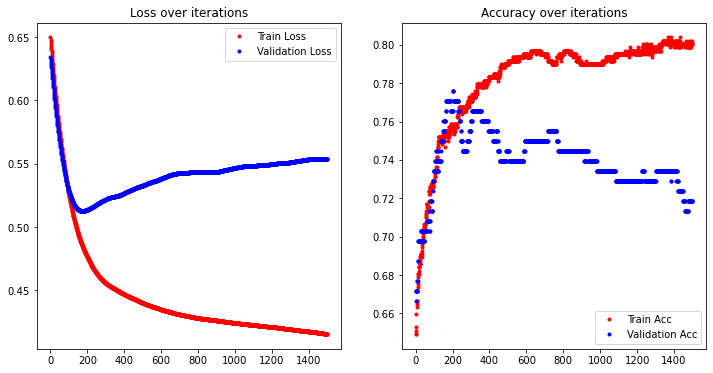

In [25]:
n = len(run_hist_2.history["loss"])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), (run_hist_2.history["loss"]),'r.', label="Train Loss")
ax.plot(range(n), (run_hist_2.history["val_loss"]),'b.', label="Validation Loss")
ax.legend()
ax.set_title('Loss over iterations')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), (run_hist_2.history["accuracy"]),'r.', label="Train Acc")
ax.plot(range(n), (run_hist_2.history["val_accuracy"]),'b.', label="Validation Acc")
ax.legend(loc='lower right')
ax.set_title('Accuracy over iterations')

Accuracy is: 0.719
Roc-Auc is: 0.791


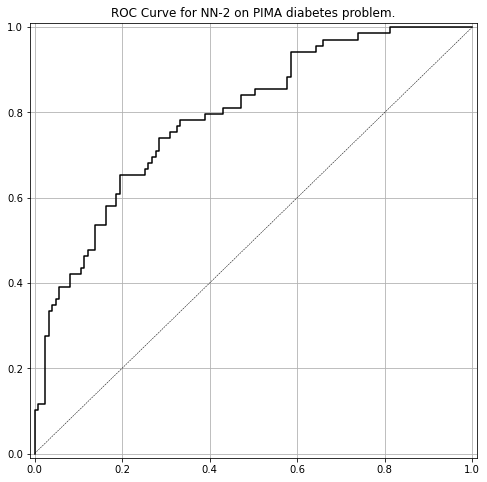

In [26]:
y_pred_class_nn_2 = model_2.predict_classes(X_test_norm)
y_pred_prob_nn_2 = model_2.predict(X_test_norm)

print(f"Accuracy is: {accuracy_score(y_test, y_pred_class_nn_2):.3f}")
print(f"Roc-Auc is: {roc_auc_score(y_test, y_pred_prob_nn_2):.3f}")

plot_roc(y_test, y_pred_prob_nn_2, 'NN-2')

***